# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.5 MB 2.6 MB/s eta 0:00:01
     --- ------------------------------------ 0.2/2.5 MB 2.5 MB/s eta 0:00:01
     --------- ------------------------------ 0.6/2.5 MB 3.9 MB/s eta 0:00:01
     ---------------- ----------------------- 1.0/2.5 MB 6.0 MB/s eta 0:00:01
     ------------------------ --------------- 1.5/2.5 MB 7.0 MB/s eta 0:00:01
     -------------------------- ------------- 1.6/2.5 MB 7.0 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 7.9 MB/s eta 0:00:00


In [5]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-win10_x86_64.whl torchvision
import torch

C:\Users\vadim_jfdr\anaconda3\envs\tf\lib\site-packages\wheel\pep425tags.py:80: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  if get_flag('Py_DEBUG',
ERROR: torch-0.4.1-cp39-cp39-win10_x86_64.whl is not a supported wheel on this platform.


In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

AttributeError: module 'PIL' has no attribute 'PILLOW_VERSION'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

In [ ]:
!ls train

dataset  __MACOSX


In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 18 02:01:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.61                 Driver Version: 531.61       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   49C    P8               12W / 220W|   5095MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

EPOCHS = 50
BATCH_SIZE = 32

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

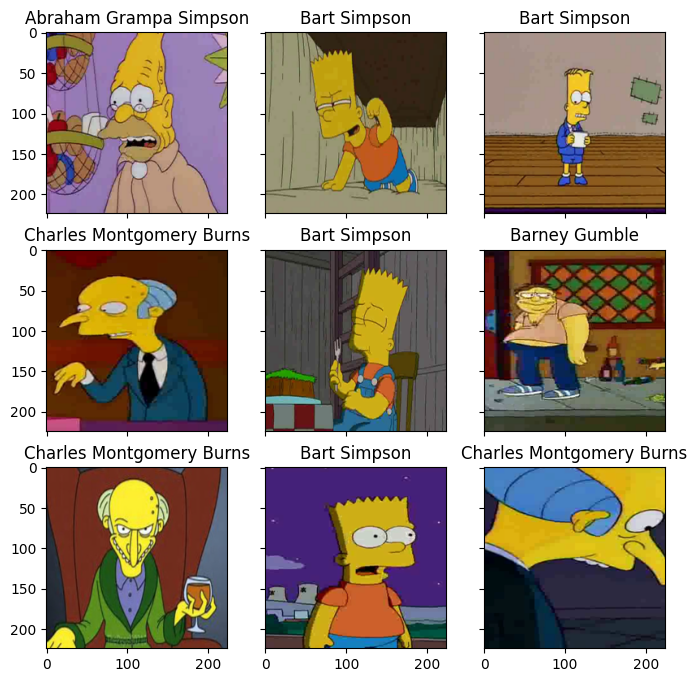

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [13]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [18]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [31]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.926515629370658


epoch:   7%|▋         | 1/15 [03:03<42:51, 183.70s/it]


Epoch 001 train_loss: 2.9265     val_loss 2.3215 train_acc 0.1826 val_acc 0.3586
loss 1.8937945624386188


epoch:  13%|█▎        | 2/15 [04:16<25:38, 118.32s/it]


Epoch 002 train_loss: 1.8938     val_loss 1.6815 train_acc 0.4824 val_acc 0.5365
loss 1.3358816367151236


epoch:  20%|██        | 3/15 [05:28<19:29, 97.45s/it] 


Epoch 003 train_loss: 1.3359     val_loss 1.2744 train_acc 0.6307 val_acc 0.6561
loss 0.9560805421185665


epoch:  27%|██▋       | 4/15 [06:41<16:03, 87.61s/it]


Epoch 004 train_loss: 0.9561     val_loss 1.0692 train_acc 0.7379 val_acc 0.7241
loss 0.6947928815785848


epoch:  33%|███▎      | 5/15 [07:53<13:39, 81.93s/it]


Epoch 005 train_loss: 0.6948     val_loss 0.9979 train_acc 0.8076 val_acc 0.7465
loss 0.5238583766204459


epoch:  40%|████      | 6/15 [09:06<11:49, 78.88s/it]


Epoch 006 train_loss: 0.5239     val_loss 0.9173 train_acc 0.8552 val_acc 0.7757
loss 0.38545644331512974


epoch:  47%|████▋     | 7/15 [10:19<10:16, 77.02s/it]


Epoch 007 train_loss: 0.3855     val_loss 0.9701 train_acc 0.8877 val_acc 0.7770
loss 0.2807622939714604


epoch:  53%|█████▎    | 8/15 [11:31<08:48, 75.55s/it]


Epoch 008 train_loss: 0.2808     val_loss 0.9847 train_acc 0.9162 val_acc 0.7898
loss 0.22360343967541682


epoch:  60%|██████    | 9/15 [12:43<07:26, 74.39s/it]


Epoch 009 train_loss: 0.2236     val_loss 1.0540 train_acc 0.9318 val_acc 0.7872
loss 0.1739793834970881


epoch:  67%|██████▋   | 10/15 [13:56<06:09, 73.81s/it]


Epoch 010 train_loss: 0.1740     val_loss 1.1175 train_acc 0.9456 val_acc 0.7904
loss 0.12547753283332674


epoch:  73%|███████▎  | 11/15 [15:08<04:53, 73.42s/it]


Epoch 011 train_loss: 0.1255     val_loss 1.2049 train_acc 0.9606 val_acc 0.7929
loss 0.09949482552158095


epoch:  80%|████████  | 12/15 [16:21<03:39, 73.14s/it]


Epoch 012 train_loss: 0.0995     val_loss 1.3432 train_acc 0.9685 val_acc 0.7921
loss 0.07841222236221615


epoch:  87%|████████▋ | 13/15 [17:33<02:25, 72.87s/it]


Epoch 013 train_loss: 0.0784     val_loss 1.5413 train_acc 0.9746 val_acc 0.7895
loss 0.06056507838022288


epoch:  93%|█████████▎| 14/15 [18:46<01:12, 72.94s/it]


Epoch 014 train_loss: 0.0606     val_loss 1.5170 train_acc 0.9806 val_acc 0.7954
loss 0.042714290642170354


epoch: 100%|██████████| 15/15 [19:59<00:00, 79.94s/it]


Epoch 015 train_loss: 0.0427     val_loss 1.6218 train_acc 0.9868 val_acc 0.7925


Построим кривые обучения

In [21]:
loss, acc, val_loss, val_acc = zip(*history)

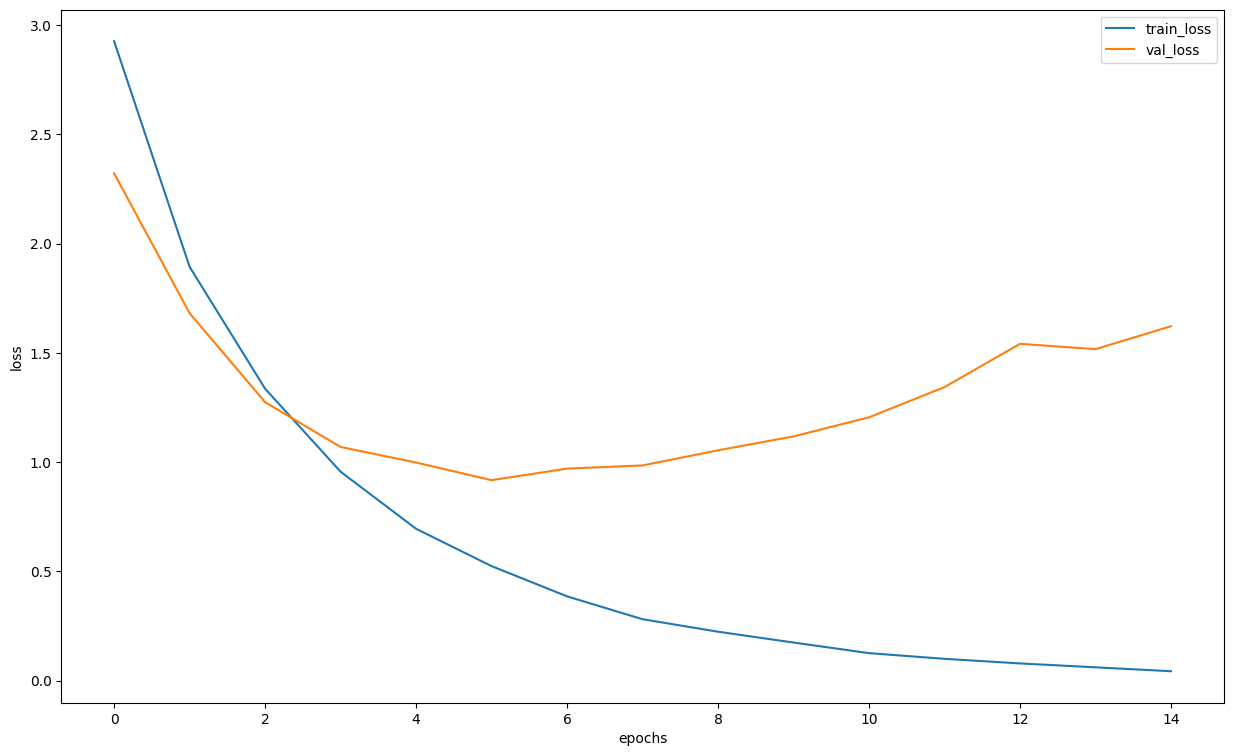

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [14]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [24]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

RuntimeError: running_mean should contain 8 elements not 394272

In [26]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [27]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

actual_labels = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [28]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')


0.8595238095238095

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

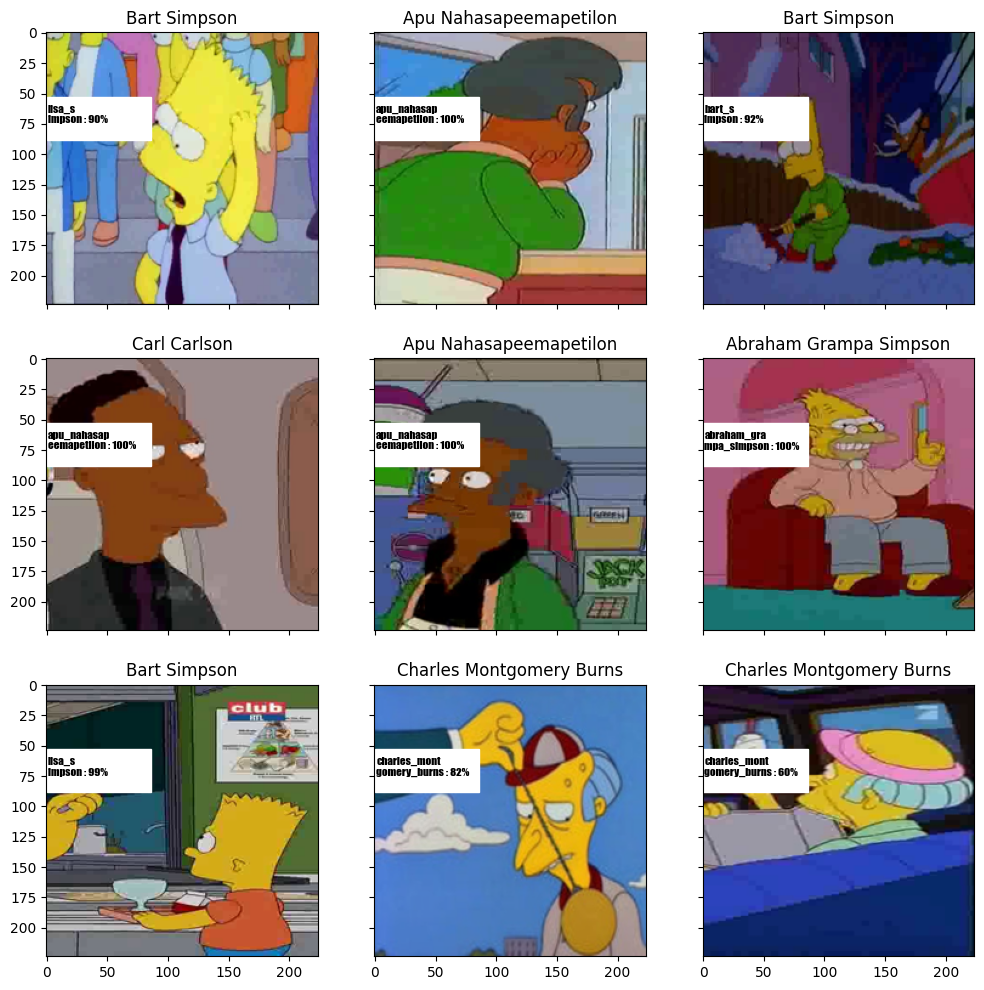

In [29]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [49]:
!ls 

"ls" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [50]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Моя модель

In [21]:
# Очень простая сеть
class MyCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.transform = nn.Sequential(
            transforms.RandomGrayscale(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(0,360))
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, n_classes),
        )
  
  
    def forward(self, x):
        x = self.transform(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [15]:
n_classes = len(np.unique(train_val_labels))
my_cnn = MyCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn)

we will classify :42
MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv4): Sequential(
    (0):

In [16]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [24]:
history = train(train_dataset, val_dataset, model=my_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.197772990207671


epoch:   2%|▏         | 1/50 [03:23<2:46:29, 203.87s/it]


Epoch 001 train_loss: 2.1978     val_loss 1.8436 train_acc 0.4286 val_acc 0.4857
loss 1.1747365043424363


epoch:   4%|▍         | 2/50 [04:47<1:46:37, 133.28s/it]


Epoch 002 train_loss: 1.1747     val_loss 1.0941 train_acc 0.6760 val_acc 0.7073
loss 0.7651813672267599


epoch:   6%|▌         | 3/50 [06:10<1:26:12, 110.05s/it]


Epoch 003 train_loss: 0.7652     val_loss 0.9589 train_acc 0.7869 val_acc 0.7489
loss 0.5302923571021058


epoch:   8%|▊         | 4/50 [07:32<1:16:06, 99.27s/it] 


Epoch 004 train_loss: 0.5303     val_loss 0.8307 train_acc 0.8458 val_acc 0.7923
loss 0.37523060813437026


epoch:  10%|█         | 5/50 [08:55<1:09:59, 93.32s/it]


Epoch 005 train_loss: 0.3752     val_loss 0.8852 train_acc 0.8882 val_acc 0.8028
loss 0.2736251657945319


epoch:  12%|█▏        | 6/50 [10:18<1:05:54, 89.87s/it]


Epoch 006 train_loss: 0.2736     val_loss 0.8249 train_acc 0.9184 val_acc 0.8173
loss 0.2204157487568836


epoch:  14%|█▍        | 7/50 [11:41<1:02:48, 87.64s/it]


Epoch 007 train_loss: 0.2204     val_loss 0.9407 train_acc 0.9321 val_acc 0.7977
loss 0.18320114148506747


epoch:  16%|█▌        | 8/50 [13:05<1:00:31, 86.46s/it]


Epoch 008 train_loss: 0.1832     val_loss 1.0880 train_acc 0.9420 val_acc 0.8024
loss 0.1434081110768592


epoch:  18%|█▊        | 9/50 [14:29<58:23, 85.45s/it]  


Epoch 009 train_loss: 0.1434     val_loss 1.0988 train_acc 0.9550 val_acc 0.8133
loss 0.13991065934926644


epoch:  20%|██        | 10/50 [15:52<56:28, 84.72s/it]


Epoch 010 train_loss: 0.1399     val_loss 1.0621 train_acc 0.9564 val_acc 0.8147
loss 0.119806992241625


epoch:  22%|██▏       | 11/50 [17:15<54:45, 84.24s/it]


Epoch 011 train_loss: 0.1198     val_loss 1.0690 train_acc 0.9613 val_acc 0.8208
loss 0.13476479913880623


epoch:  24%|██▍       | 12/50 [18:38<53:10, 83.96s/it]


Epoch 012 train_loss: 0.1348     val_loss 1.1365 train_acc 0.9578 val_acc 0.8149
loss 0.08761930559337718


epoch:  26%|██▌       | 13/50 [20:02<51:45, 83.94s/it]


Epoch 013 train_loss: 0.0876     val_loss 1.3460 train_acc 0.9727 val_acc 0.8017
loss 0.09438110819264463


epoch:  28%|██▊       | 14/50 [21:25<50:13, 83.70s/it]


Epoch 014 train_loss: 0.0944     val_loss 1.2294 train_acc 0.9719 val_acc 0.8290
loss 0.08563801771794156


epoch:  30%|███       | 15/50 [22:48<48:45, 83.58s/it]


Epoch 015 train_loss: 0.0856     val_loss 1.2510 train_acc 0.9748 val_acc 0.8124
loss 0.10421536210678935


epoch:  32%|███▏      | 16/50 [24:12<47:20, 83.54s/it]


Epoch 016 train_loss: 0.1042     val_loss 1.3199 train_acc 0.9682 val_acc 0.8202
loss 0.0832093165337831


epoch:  34%|███▍      | 17/50 [25:35<45:56, 83.53s/it]


Epoch 017 train_loss: 0.0832     val_loss 1.3230 train_acc 0.9751 val_acc 0.8261
loss 0.07753345828043878


epoch:  36%|███▌      | 18/50 [26:59<44:33, 83.55s/it]


Epoch 018 train_loss: 0.0775     val_loss 1.3195 train_acc 0.9780 val_acc 0.8286
loss 0.07164199405168824


epoch:  38%|███▊      | 19/50 [28:22<43:03, 83.35s/it]


Epoch 019 train_loss: 0.0716     val_loss 1.2351 train_acc 0.9785 val_acc 0.8405
loss 0.07233280960428437


epoch:  40%|████      | 20/50 [29:45<41:35, 83.20s/it]


Epoch 020 train_loss: 0.0723     val_loss 1.3262 train_acc 0.9784 val_acc 0.8309
loss 0.06844063738870117


epoch:  42%|████▏     | 21/50 [31:07<40:08, 83.04s/it]


Epoch 021 train_loss: 0.0684     val_loss 1.5121 train_acc 0.9797 val_acc 0.8259
loss 0.06492128167213507


epoch:  44%|████▍     | 22/50 [32:30<38:40, 82.89s/it]


Epoch 022 train_loss: 0.0649     val_loss 1.4898 train_acc 0.9811 val_acc 0.8214
loss 0.06629891179212133


epoch:  46%|████▌     | 23/50 [33:52<37:15, 82.79s/it]


Epoch 023 train_loss: 0.0663     val_loss 1.4357 train_acc 0.9819 val_acc 0.8275
loss 0.06762627578815565


epoch:  48%|████▊     | 24/50 [35:16<35:57, 82.99s/it]


Epoch 024 train_loss: 0.0676     val_loss 1.4756 train_acc 0.9808 val_acc 0.8336
loss 0.06856789553845899


epoch:  50%|█████     | 25/50 [36:39<34:37, 83.08s/it]


Epoch 025 train_loss: 0.0686     val_loss 1.4190 train_acc 0.9808 val_acc 0.8345
loss 0.05265438079075969


epoch:  52%|█████▏    | 26/50 [38:02<33:13, 83.07s/it]


Epoch 026 train_loss: 0.0527     val_loss 1.4589 train_acc 0.9842 val_acc 0.8326
loss 0.048258754338825774


epoch:  54%|█████▍    | 27/50 [39:25<31:50, 83.07s/it]


Epoch 027 train_loss: 0.0483     val_loss 1.3520 train_acc 0.9862 val_acc 0.8433
loss 0.06794418213564377


epoch:  56%|█████▌    | 28/50 [40:49<30:28, 83.11s/it]


Epoch 028 train_loss: 0.0679     val_loss 1.3471 train_acc 0.9816 val_acc 0.8452
loss 0.039807371929036724


epoch:  58%|█████▊    | 29/50 [42:12<29:04, 83.09s/it]


Epoch 029 train_loss: 0.0398     val_loss 1.4916 train_acc 0.9889 val_acc 0.8426
loss 0.04791358809412376


epoch:  60%|██████    | 30/50 [43:35<27:43, 83.16s/it]


Epoch 030 train_loss: 0.0479     val_loss 1.3424 train_acc 0.9865 val_acc 0.8464
loss 0.061185738908929276


epoch:  62%|██████▏   | 31/50 [44:58<26:21, 83.25s/it]


Epoch 031 train_loss: 0.0612     val_loss 1.4720 train_acc 0.9835 val_acc 0.8387
loss 0.047452664141117075


epoch:  64%|██████▍   | 32/50 [46:22<25:02, 83.47s/it]


Epoch 032 train_loss: 0.0475     val_loss 1.4145 train_acc 0.9861 val_acc 0.8307
loss 0.04252945175927254


epoch:  66%|██████▌   | 33/50 [47:46<23:41, 83.64s/it]


Epoch 033 train_loss: 0.0425     val_loss 1.4994 train_acc 0.9874 val_acc 0.8401
loss 0.05200536887405061


epoch:  68%|██████▊   | 34/50 [49:11<22:23, 83.95s/it]


Epoch 034 train_loss: 0.0520     val_loss 1.4957 train_acc 0.9856 val_acc 0.8250
loss 0.043763526707000934


epoch:  70%|███████   | 35/50 [50:35<21:00, 84.02s/it]


Epoch 035 train_loss: 0.0438     val_loss 1.4857 train_acc 0.9875 val_acc 0.8389
loss 0.052928766968619055


epoch:  72%|███████▏  | 36/50 [51:59<19:35, 83.96s/it]


Epoch 036 train_loss: 0.0529     val_loss 1.4796 train_acc 0.9854 val_acc 0.8420
loss 0.03793290798724126


epoch:  74%|███████▍  | 37/50 [53:23<18:12, 84.04s/it]


Epoch 037 train_loss: 0.0379     val_loss 1.5979 train_acc 0.9896 val_acc 0.8441
loss 0.03969090856065982


epoch:  76%|███████▌  | 38/50 [54:47<16:49, 84.09s/it]


Epoch 038 train_loss: 0.0397     val_loss 1.3924 train_acc 0.9894 val_acc 0.8376
loss 0.035597144644889035


epoch:  78%|███████▊  | 39/50 [56:11<15:23, 83.93s/it]


Epoch 039 train_loss: 0.0356     val_loss 1.5411 train_acc 0.9911 val_acc 0.8391
loss 0.039339799779784704


epoch:  80%|████████  | 40/50 [57:35<13:58, 83.85s/it]


Epoch 040 train_loss: 0.0393     val_loss 1.4529 train_acc 0.9889 val_acc 0.8395
loss 0.03208369682133654


epoch:  82%|████████▏ | 41/50 [58:59<12:34, 83.87s/it]


Epoch 041 train_loss: 0.0321     val_loss 1.5357 train_acc 0.9903 val_acc 0.8286
loss 0.036573223258067944


epoch:  84%|████████▍ | 42/50 [1:00:23<11:11, 83.90s/it]


Epoch 042 train_loss: 0.0366     val_loss 1.5908 train_acc 0.9897 val_acc 0.8357
loss 0.059346787951788625


epoch:  86%|████████▌ | 43/50 [1:01:46<09:47, 83.86s/it]


Epoch 043 train_loss: 0.0593     val_loss 1.7303 train_acc 0.9841 val_acc 0.8445
loss 0.02301347818330452


epoch:  88%|████████▊ | 44/50 [1:03:10<08:23, 83.90s/it]


Epoch 044 train_loss: 0.0230     val_loss 1.6444 train_acc 0.9934 val_acc 0.8429
loss 0.029529351190712864


epoch:  90%|█████████ | 45/50 [1:04:34<06:59, 83.85s/it]


Epoch 045 train_loss: 0.0295     val_loss 1.6722 train_acc 0.9921 val_acc 0.8391
loss 0.059429411463672456


epoch:  92%|█████████▏| 46/50 [1:05:58<05:35, 83.98s/it]


Epoch 046 train_loss: 0.0594     val_loss 1.8483 train_acc 0.9846 val_acc 0.8286
loss 0.024424309250241565


epoch:  94%|█████████▍| 47/50 [1:07:23<04:12, 84.12s/it]


Epoch 047 train_loss: 0.0244     val_loss 1.7381 train_acc 0.9931 val_acc 0.8397
loss 0.014470478312964977


epoch:  96%|█████████▌| 48/50 [1:08:47<02:48, 84.08s/it]


Epoch 048 train_loss: 0.0145     val_loss 1.7524 train_acc 0.9957 val_acc 0.8275
loss 0.046380573253494796


epoch:  98%|█████████▊| 49/50 [1:10:11<01:24, 84.09s/it]


Epoch 049 train_loss: 0.0464     val_loss 1.7006 train_acc 0.9884 val_acc 0.8357
loss 0.039962667889155534


epoch: 100%|██████████| 50/50 [1:11:35<00:00, 85.91s/it]


Epoch 050 train_loss: 0.0400     val_loss 1.6637 train_acc 0.9887 val_acc 0.8464


In [65]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))

In [66]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn, imgs)

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [68]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

actual_labels = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

IndexError: index 462 is out of bounds for axis 0 with size 42

In [52]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')


0.8770833333333334

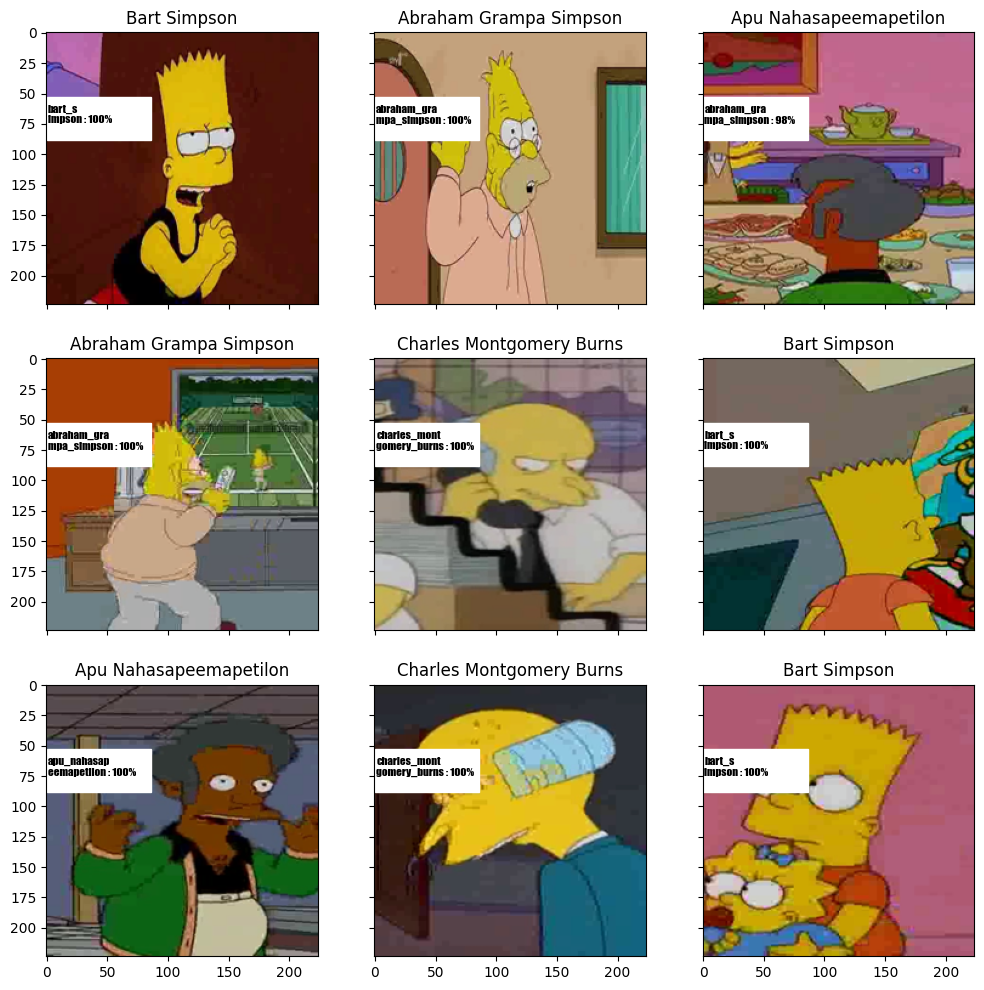

In [32]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [87]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [88]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [89]:
my_submit.to_csv('my_cnn_baseline.csv', index=False)

# Transfer Learning

In [15]:
from torchvision import models

In [16]:
ft_cnn = models.resnet50()

In [17]:
ft_cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
in_features = 2048

In [20]:
n_classes = len(np.unique(train_val_labels))
ft_cnn.fc = nn.Linear(in_features, n_classes)
ft_cnn = ft_cnn.to(DEVICE)

In [21]:
print(ft_cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
history = train(train_dataset, val_dataset, model=ft_cnn, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 2.4621233462345766


epoch:   2%|▏         | 1/50 [04:06<3:21:28, 246.70s/it]


Epoch 001 train_loss: 2.4621     val_loss 2.4927 train_acc 0.3391 val_acc 0.4398
loss 3.101615689090729


epoch:   4%|▍         | 2/50 [06:17<2:22:55, 178.65s/it]


Epoch 002 train_loss: 3.1016     val_loss 2.9488 train_acc 0.1079 val_acc 0.1408
loss 2.6548487320623018


epoch:   6%|▌         | 3/50 [08:28<2:02:58, 156.98s/it]


Epoch 003 train_loss: 2.6548     val_loss 2.0649 train_acc 0.2363 val_acc 0.4327
loss 1.785398790483847


epoch:   8%|▊         | 4/50 [10:40<1:52:35, 146.85s/it]


Epoch 004 train_loss: 1.7854     val_loss 1.4852 train_acc 0.5018 val_acc 0.5854
loss 1.2872664090501054


epoch:  10%|█         | 5/50 [12:51<1:45:57, 141.28s/it]


Epoch 005 train_loss: 1.2873     val_loss 1.2191 train_acc 0.6399 val_acc 0.6561
loss 0.9584299657624105


epoch:  12%|█▏        | 6/50 [15:03<1:41:09, 137.95s/it]


Epoch 006 train_loss: 0.9584     val_loss 0.9329 train_acc 0.7278 val_acc 0.7417
loss 0.7071848183925368


epoch:  14%|█▍        | 7/50 [17:14<1:37:23, 135.89s/it]


Epoch 007 train_loss: 0.7072     val_loss 0.8026 train_acc 0.7969 val_acc 0.7786
loss 0.5268299104727122


epoch:  16%|█▌        | 8/50 [19:26<1:34:11, 134.57s/it]


Epoch 008 train_loss: 0.5268     val_loss 0.7509 train_acc 0.8485 val_acc 0.8066
loss 0.39863934762516295


epoch:  18%|█▊        | 9/50 [21:38<1:31:24, 133.77s/it]


Epoch 009 train_loss: 0.3986     val_loss 0.7585 train_acc 0.8804 val_acc 0.8074
loss 0.3047516801204034


epoch:  20%|██        | 10/50 [23:50<1:28:45, 133.14s/it]


Epoch 010 train_loss: 0.3048     val_loss 0.7298 train_acc 0.9082 val_acc 0.8405
loss 0.23608456078839193


epoch:  22%|██▏       | 11/50 [26:02<1:26:16, 132.73s/it]


Epoch 011 train_loss: 0.2361     val_loss 0.6564 train_acc 0.9276 val_acc 0.8464
loss 0.18842050122611234


epoch:  24%|██▍       | 12/50 [28:14<1:24:01, 132.66s/it]


Epoch 012 train_loss: 0.1884     val_loss 0.6492 train_acc 0.9430 val_acc 0.8536
loss 0.14628515172141038


epoch:  26%|██▌       | 13/50 [30:26<1:21:40, 132.46s/it]


Epoch 013 train_loss: 0.1463     val_loss 0.7460 train_acc 0.9539 val_acc 0.8558
loss 0.12590634757992802


epoch:  28%|██▊       | 14/50 [32:38<1:19:26, 132.39s/it]


Epoch 014 train_loss: 0.1259     val_loss 0.6704 train_acc 0.9615 val_acc 0.8521
loss 0.11552200515965298


epoch:  30%|███       | 15/50 [34:51<1:17:13, 132.39s/it]


Epoch 015 train_loss: 0.1155     val_loss 0.7931 train_acc 0.9639 val_acc 0.8479
loss 0.09394080257510119


epoch:  32%|███▏      | 16/50 [37:03<1:15:03, 132.47s/it]


Epoch 016 train_loss: 0.0939     val_loss 0.6921 train_acc 0.9718 val_acc 0.8626
loss 0.0959709802765502


epoch:  34%|███▍      | 17/50 [39:16<1:12:50, 132.43s/it]


Epoch 017 train_loss: 0.0960     val_loss 0.7530 train_acc 0.9711 val_acc 0.8548
loss 0.07491790796920178


epoch:  36%|███▌      | 18/50 [41:28<1:10:34, 132.32s/it]


Epoch 018 train_loss: 0.0749     val_loss 0.8247 train_acc 0.9778 val_acc 0.8475
loss 0.07289461611489463


epoch:  38%|███▊      | 19/50 [43:40<1:08:18, 132.21s/it]


Epoch 019 train_loss: 0.0729     val_loss 0.7333 train_acc 0.9785 val_acc 0.8567
loss 0.06641586604196806


epoch:  40%|████      | 20/50 [45:52<1:06:07, 132.25s/it]


Epoch 020 train_loss: 0.0664     val_loss 0.7710 train_acc 0.9803 val_acc 0.8657
loss 0.0701811563150217


epoch:  42%|████▏     | 21/50 [48:04<1:03:53, 132.18s/it]


Epoch 021 train_loss: 0.0702     val_loss 0.8222 train_acc 0.9784 val_acc 0.8665
loss 0.049683317321332666


epoch:  44%|████▍     | 22/50 [50:16<1:01:40, 132.14s/it]


Epoch 022 train_loss: 0.0497     val_loss 0.7658 train_acc 0.9847 val_acc 0.8607
loss 0.0689310367299593


epoch:  46%|████▌     | 23/50 [52:28<59:27, 132.14s/it]  


Epoch 023 train_loss: 0.0689     val_loss 0.9377 train_acc 0.9785 val_acc 0.8462
loss 0.05704001253637478


epoch:  48%|████▊     | 24/50 [54:40<57:16, 132.18s/it]


Epoch 024 train_loss: 0.0570     val_loss 0.8226 train_acc 0.9833 val_acc 0.8825
loss 0.04340583731487404


epoch:  50%|█████     | 25/50 [56:53<55:04, 132.16s/it]


Epoch 025 train_loss: 0.0434     val_loss 0.9377 train_acc 0.9855 val_acc 0.8634
loss 0.054145627979608014


epoch:  52%|█████▏    | 26/50 [59:05<52:51, 132.15s/it]


Epoch 026 train_loss: 0.0541     val_loss 0.8703 train_acc 0.9838 val_acc 0.8590
loss 0.05665930414344437


epoch:  54%|█████▍    | 27/50 [1:01:17<50:37, 132.08s/it]


Epoch 027 train_loss: 0.0567     val_loss 0.8155 train_acc 0.9844 val_acc 0.8603
loss 0.039960908017308894


epoch:  56%|█████▌    | 28/50 [1:03:29<48:28, 132.22s/it]


Epoch 028 train_loss: 0.0400     val_loss 0.8163 train_acc 0.9895 val_acc 0.8707
loss 0.04505813707968935


epoch:  58%|█████▊    | 29/50 [1:05:42<46:17, 132.25s/it]


Epoch 029 train_loss: 0.0451     val_loss 0.8973 train_acc 0.9868 val_acc 0.8630
loss 0.04793883605908493


epoch:  60%|██████    | 30/50 [1:07:54<44:03, 132.18s/it]


Epoch 030 train_loss: 0.0479     val_loss 0.9153 train_acc 0.9862 val_acc 0.8630
loss 0.054209945933731726


epoch:  62%|██████▏   | 31/50 [1:10:06<41:50, 132.13s/it]


Epoch 031 train_loss: 0.0542     val_loss 0.9426 train_acc 0.9843 val_acc 0.8621
loss 0.03351940560251707


epoch:  64%|██████▍   | 32/50 [1:12:18<39:38, 132.11s/it]


Epoch 032 train_loss: 0.0335     val_loss 0.9576 train_acc 0.9910 val_acc 0.8538
loss 0.04389091733277748


epoch:  66%|██████▌   | 33/50 [1:14:30<37:24, 132.05s/it]


Epoch 033 train_loss: 0.0439     val_loss 0.7597 train_acc 0.9870 val_acc 0.8678
loss 0.03420326670962887


epoch:  68%|██████▊   | 34/50 [1:16:41<35:11, 132.00s/it]


Epoch 034 train_loss: 0.0342     val_loss 0.7620 train_acc 0.9908 val_acc 0.8647
loss 0.030379738999666582


epoch:  70%|███████   | 35/50 [1:18:53<32:59, 131.94s/it]


Epoch 035 train_loss: 0.0304     val_loss 0.8265 train_acc 0.9906 val_acc 0.8626
loss 0.05186694764891621


epoch:  72%|███████▏  | 36/50 [1:21:05<30:47, 131.97s/it]


Epoch 036 train_loss: 0.0519     val_loss 0.9782 train_acc 0.9861 val_acc 0.8569
loss 0.023208448442111788


epoch:  74%|███████▍  | 37/50 [1:23:17<28:35, 131.95s/it]


Epoch 037 train_loss: 0.0232     val_loss 0.9484 train_acc 0.9936 val_acc 0.8626
loss 0.030818149951959403


epoch:  76%|███████▌  | 38/50 [1:25:29<26:23, 131.94s/it]


Epoch 038 train_loss: 0.0308     val_loss 0.8947 train_acc 0.9907 val_acc 0.8705
loss 0.0506822859156345


epoch:  78%|███████▊  | 39/50 [1:27:41<24:11, 132.00s/it]


Epoch 039 train_loss: 0.0507     val_loss 0.8768 train_acc 0.9848 val_acc 0.8645
loss 0.03522196908951014


epoch:  80%|████████  | 40/50 [1:29:53<22:00, 132.07s/it]


Epoch 040 train_loss: 0.0352     val_loss 0.7809 train_acc 0.9905 val_acc 0.8745


epoch:  80%|████████  | 40/50 [1:31:34<22:53, 137.37s/it]


KeyboardInterrupt: 

In [24]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(ft_cnn, ex_img.unsqueeze(0))

In [25]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(ft_cnn, imgs)

In [28]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

actual_labels = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [29]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')


0.973076923076923

In [30]:
len(test_files)

991

In [31]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(ft_cnn, test_loader)
print(probs.shape)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


(991, 42)


In [33]:
import pandas as pd
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [34]:
my_submit.to_csv('ft_cnn_baseline.csv', index=False)